# Import Library

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Load Data

Melakukan Data Loading menggunakan dataset BlaBla yang sudah disediakan

In [ ]:
true_df = pd.read_excel('https://drive.google.com/uc?id=1jFLCgdYaQGnNVnfSKXe2I1KfFO8PDIdM')

true_df

,A,UMUR_TAHUN,B,C,D,E,F,G,H,I,J,K,L,M,N
0,1,17,0,1,0,0,0,0,0,1,0,0,0,1,0
1,5,70,0,0,0,0,0,0,0,1,1,1,0,1,1
2,3,39,0,0,0,0,0,1,0,0,0,0,0,1,0
3,5,63,0,0,0,0,0,0,0,0,1,0,0,1,0
4,3,40,0,0,0,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303,2,26,0,0,1,0,0,0,1,0,1,1,1,1,1
2304,1,9,1,0,1,0,0,0,0,1,0,0,0,1,1
2305,1,19,0,0,1,0,0,0,0,0,1,1,1,1,1
2306,4,42,0,0,0,0,0,0,0,1,0,1,1,1,1


# Data Preprocessing

Melakukan copy dataframe untuk trial and error

In [ ]:
df = true_df.copy()

### Missing Value

Mengecek missing value setiap fitur dataset

In [ ]:
print(df.isna().sum())

A             0
UMUR_TAHUN    0
B             0
C             0
D             0
E             0
F             0
G             0
H             0
I             0
J             0
K             0
L             0
M             0
N             0
dtype: int64


Karena tidak terdapat missing value, kita tidak perlu melakukan handling missing value

### Outlier

Mengecek nilai unik fitur UMUR_TAHUN

In [ ]:
print(df['UMUR_TAHUN'].unique())

[17 70 39 63 40 65 48 74 53 37 44 54 20 64 45 72 29 56 61 62 38 28 52 55
 31 43 23 33 18 51 35 25 41 19 69 57 60 68 42 47 15 49 58 26 50 30 46 32
 27 36 59 13 22 66 16 21 24 34 10 12 14 8 11 7 6 4 73 9 3 2 5 0 1 67 78 77
 80 'Y' 76]


Karena terdapat nilai yang tidak diinginkan (Y), kita akan mengecek berapa record yang memiliki nilai Y pada fitur UMUR_TAHUN

In [ ]:
print(df[df['UMUR_TAHUN'] == "Y"])

      A UMUR_TAHUN  B  C  D  E  F  G  H  I  J  K  L  M  N
2151  5          Y  0  0  0  0  0  0  1  0  0  1  0  1  0


Karena hanya terdapat 1 record, kita dapat menghapus record dimana terdapat kesalahan, kesalahan ini mungkin diakibatkan karena kesalahan input pembuat dataset atau sengaja ditambahkan untuk pembelajaran data cleaning yang lebih komprehensif

In [ ]:
df = df[df['UMUR_TAHUN'] != "Y"]
df.loc[:, 'UMUR_TAHUN'] = pd.to_numeric(df['UMUR_TAHUN'])

Melihat apakah terdapat outlier pada dataset

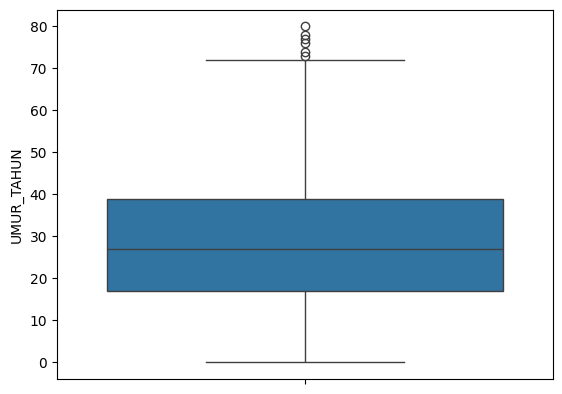

In [ ]:
sns.boxplot(df['UMUR_TAHUN'])
plt.show()

Karena jumlah missing value tidak signifikan, kami memutuskan untuk menghapus data yang merupakan outlier

In [ ]:
Q1 = df.loc[:, "UMUR_TAHUN"].quantile(0.25)
Q3 = df.loc[:, "UMUR_TAHUN"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df["UMUR_TAHUN"] >= lower_bound) & (df["UMUR_TAHUN"] <= upper_bound)]

### Binning Fitur Umur

Melakukan binning fitur umum sesuai dengan ketentuan yang dijelaskan pada modul

In [ ]:
def encode_age(age):
    if age <= 20:
        return 1
    elif 21 <= age <= 30:
        return 2
    elif 31 <= age <= 40:
        return 3
    elif 41 <= age <= 50:
        return 4
    else:
        return 5

df['UMUR_TAHUN_ENCODED'] = df['UMUR_TAHUN'].apply(encode_age)
df.drop('UMUR_TAHUN', axis=1, inplace=True)

Melihat distribusi fitur UMUR_TAHUN setelah binning

In [ ]:
print("Distribusi encoding umur:")
print(df['UMUR_TAHUN_ENCODED'].value_counts().sort_index())

Distribusi encoding umur:
UMUR_TAHUN_ENCODED
1    785
2    566
3    451
4    294
5    205
Name: count, dtype: int64


### Dataframe Setelah Data Preprocessing

In [ ]:
df

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,UMUR_TAHUN_ENCODED
0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1
1,5,0,0,0,0,0,0,0,1,1,1,0,1,1,5
2,3,0,0,0,0,0,1,0,0,0,0,0,1,0,3
3,5,0,0,0,0,0,0,0,0,1,0,0,1,0,5
4,3,0,0,0,0,0,1,0,0,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303,2,0,0,1,0,0,0,1,0,1,1,1,1,1,2
2304,1,1,0,1,0,0,0,0,1,0,0,0,1,1,1
2305,1,0,0,1,0,0,0,0,0,1,1,1,1,1,1
2306,4,0,0,0,0,0,0,0,1,0,1,1,1,1,4


# Scenario 1

### Pisahkan Fitur (X) dan Target(y)

In [ ]:
X_scenario1 = df.drop(['A', 'N'], axis=1)
y_scenario1 = df['N']

print(X_scenario1.shape)
print(y_scenario1.shape)

(2301, 13)
(2301,)


### Imbalanced Data

Melihat jumlah nilai yes (1) dan no (0) pada target y

In [ ]:
print(y_scenario1.value_counts())

N
0    1624
1     677
Name: count, dtype: int64


Melakukan oversampling dengan metode SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_scenario1, y_scenario1 = smote.fit_resample(X_scenario1, y_scenario1)

print(y_scenario1.value_counts())

N
0    1624
1    1624
Name: count, dtype: int64


### Data Splitting

Melakukan data splitting dengan proporsi train : test = 80:20

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scenario1, y_scenario1, test_size=0.2, random_state=42)

print(X_train1.shape)
print(X_test1.shape)
print(y_train1.shape)
print(y_test1.shape)

(2598, 13)
(650, 13)
(2598,)
(650,)


### Preview X_train Scenario 1

In [ ]:
X_train1

,B,C,D,E,F,G,H,I,J,K,L,M,UMUR_TAHUN_ENCODED
794,0,0,0,0,0,1,0,0,0,0,0,1,3
670,0,0,0,0,0,1,0,1,0,1,0,1,1
3011,0,0,1,0,0,0,0,1,0,1,0,1,1
2225,0,0,0,0,0,0,1,1,0,0,0,1,3
1188,0,0,1,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0,0,0,0,0,0,0,0,0,0,0,1,1
1130,0,0,0,0,0,0,0,0,0,0,0,1,1
1294,0,0,0,0,0,0,0,1,0,0,0,1,2
860,0,0,0,0,0,0,0,0,0,0,0,1,2


# Scenario 2

### Pisahkan Fitur (X) dan Target(y)

In [ ]:
X_scenario2 = df.drop(['A', 'N'], axis=1)
y_scenario2 = df['N']

print(X_scenario2.shape)
print(y_scenario2.shape)

(2301, 13)
(2301,)


### Seleksi Fitur Chi-Square

Melakukan seleksi fitur menggunakan Chi-Square untuk melihat fitur yang paling relevan untuk mengklasifikasikan data terhadap target

In [ ]:
selector = SelectKBest(score_func=chi2, k=5)
selector.fit_transform(X_scenario2, y_scenario2)

# Menampilkan skor chi-square
scores = selector.scores_
features = X_scenario2.columns

for f, s in zip(features, scores):
    print(f"{f}: {s:.2f}")

B: 0.17
C: 62.65
D: 545.78
E: 197.16
F: 489.71
G: 160.55
H: 75.56
I: 432.09
J: 287.40
K: 582.69
L: 265.08
M: 0.00
UMUR_TAHUN_ENCODED: 4.91


Melihat fitur terbaik berdasarkan seleksi Chi-Square

In [ ]:
selected_features = features[selector.get_support()]
print("Fitur terpilih:", selected_features.tolist())

Fitur terpilih: ['D', 'F', 'I', 'J', 'K']


Menerapkan fitur yang terpilih kedalam fitur (X)

In [ ]:
X_scenario2 = X_scenario2[selected_features]
X_scenario2

,D,F,I,J,K
0,0,0,1,0,0
1,0,0,1,1,1
2,0,0,0,0,0
3,0,0,0,1,0
4,0,0,0,0,1
...,...,...,...,...,...
2303,1,0,0,1,1
2304,1,0,1,0,0
2305,1,0,0,1,1
2306,0,0,1,0,1


### Data Splitting

Melakukan data splitting dengan proporsi train : test = 80:20

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scenario2, y_scenario2, test_size=0.2, random_state=42)

print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(1840, 5)
(461, 5)
(1840,)
(461,)


### Preview X_train Scenario 2

In [ ]:
X_train2

,D,F,I,J,K
1737,0,0,0,0,0
361,0,1,1,1,1
2176,1,0,1,1,1
352,0,0,0,0,0
1950,1,0,1,0,1
...,...,...,...,...,...
1642,0,0,0,0,0
1097,0,0,0,0,0
1132,0,0,0,0,0
1297,0,0,1,0,0


# Klasifikasi

### Scenario 1

In [ ]:
# Decision Tree
model_dt1 = DecisionTreeClassifier(random_state=42)
model_dt1.fit(X_train1, y_train1)
y_pred_dt1 = model_dt1.predict(X_test1)

print("Decision Tree")
print("Accuracy Decision Tree Scenario 1:", accuracy_score(y_test1, y_pred_dt1))
print("Precision Decision Tree Scenario 1:", precision_score(y_test1, y_pred_dt1))
print("Recall Decision Tree Scenario 1:", recall_score(y_test1, y_pred_dt1))
print("F1 Score Decision Tree Scenario 1:", f1_score(y_test1, y_pred_dt1))

# Random Forest
model_rf1 = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf1.fit(X_train1, y_train1)
y_pred_rf1 = model_rf1.predict(X_test1)

print("\nRandom Forest")
print("Accuracy Random Forest Scenario 1:", accuracy_score(y_test1, y_pred_rf1))
print("Precision Random Forest Scenario 1:", precision_score(y_test1, y_pred_rf1))
print("Recall Random Forest Scenario 1:", recall_score(y_test1, y_pred_rf1))
print("F1 Score Random Forest Scenario 1:", f1_score(y_test1, y_pred_rf1))

# SVM
model_svm1 = SVC(kernel='linear')
model_svm1.fit(X_train1, y_train1)
y_pred_svm1 = model_svm1.predict(X_test1)

print("\nSupport Vector Machine")
print("Accuracy Support Vector Machine Scenario 1:", accuracy_score(y_test1, y_pred_svm1))
print("Precision Support Vector Machine Scenario 1:", precision_score(y_test1, y_pred_svm1))
print("Recall Support Vector Machine Scenario 1:", recall_score(y_test1, y_pred_svm1))
print("F1 Score Support Vector Machine Scenario 1:", f1_score(y_test1, y_pred_svm1))

# XGBoost
model_xgboost1 = XGBClassifier(eval_metric='mlogloss')
model_xgboost1.fit(X_train1, y_train1)
y_pred_xgboost1 = model_xgboost1.predict(X_test1)

print("\nXGBoost")
print("Accuracy XGBoost Scenario 1:", accuracy_score(y_test1, y_pred_xgboost1))
print("Precision XGBoost Scenario 1:", precision_score(y_test1, y_pred_xgboost1))
print("Recall XGBoost Scenario 1:", recall_score(y_test1, y_pred_xgboost1))
print("F1 Score XGBoost Scenario 1:", f1_score(y_test1, y_pred_xgboost1))

# LightGBM
model_lightgbm1 = LGBMClassifier(verbose=-1, random_state=42)
model_lightgbm1.fit(X_train1, y_train1)
y_pred_lightgbm1 = model_lightgbm1.predict(X_test1)

print("\nLightGBM")
print("Accuracy LightGBM Scenario 1:", accuracy_score(y_test1, y_pred_lightgbm1))
print("Precision LightGBM Scenario 1:", precision_score(y_test1, y_pred_lightgbm1))
print("Recall LightGBM Scenario 1:", recall_score(y_test1, y_pred_lightgbm1))
print("F1 Score LightGBM Scenario 1:", f1_score(y_test1, y_pred_lightgbm1))

Decision Tree
Accuracy Decision Tree Scenario 1: 0.9523076923076923
Precision Decision Tree Scenario 1: 0.9572368421052632
Recall Decision Tree Scenario 1: 0.941747572815534
F1 Score Decision Tree Scenario 1: 0.9494290375203915

Random Forest
Accuracy Random Forest Scenario 1: 0.9553846153846154
Precision Random Forest Scenario 1: 0.9605263157894737
Recall Random Forest Scenario 1: 0.9449838187702265
F1 Score Random Forest Scenario 1: 0.9526916802610114

Support Vector Machine
Accuracy Support Vector Machine Scenario 1: 0.9523076923076923
Precision Support Vector Machine Scenario 1: 0.9664429530201343
Recall Support Vector Machine Scenario 1: 0.9320388349514563
F1 Score Support Vector Machine Scenario 1: 0.9489291598023064

XGBoost
Accuracy XGBoost Scenario 1: 0.9553846153846154
Precision XGBoost Scenario 1: 0.9666666666666667
Recall XGBoost Scenario 1: 0.9385113268608414
F1 Score XGBoost Scenario 1: 0.9523809523809523

LightGBM
Accuracy LightGBM Scenario 1: 0.9569230769230769
Precisio

### Scenario 2

In [ ]:
# Decision Tree
model_dt2 = DecisionTreeClassifier(random_state=42)
model_dt2.fit(X_train2, y_train2)
y_pred_dt2 = model_dt2.predict(X_test2)

print("Decision Tree")
print("Accuracy Decision Tree Scenario 1:", accuracy_score(y_test2, y_pred_dt2))
print("Precision Decision Tree Scenario 1:", precision_score(y_test2, y_pred_dt2))
print("Recall Decision Tree Scenario 1:", recall_score(y_test2, y_pred_dt2))
print("F1 Score Decision Tree Scenario 1:", f1_score(y_test2, y_pred_dt2))

# Random Forest
model_rf2 = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf2.fit(X_train2, y_train2)
y_pred_rf2 = model_rf2.predict(X_test2)

print("\nRandom Forest")
print("Accuracy Random Forest Scenario 1:", accuracy_score(y_test2, y_pred_rf2))
print("Precision Random Forest Scenario 1:", precision_score(y_test2, y_pred_rf2))
print("Recall Random Forest Scenario 1:", recall_score(y_test2, y_pred_rf2))
print("F1 Score Random Forest Scenario 1:", f1_score(y_test2, y_pred_rf2))

# SVM
model_svm2 = SVC(kernel='linear')
model_svm2.fit(X_train2, y_train2)
y_pred_svm2 = model_svm2.predict(X_test2)

print("\nSupport Vector Machine")
print("Accuracy Support Vector Machine Scenario 1:", accuracy_score(y_test2, y_pred_svm2))
print("Precision Support Vector Machine Scenario 1:", precision_score(y_test2, y_pred_svm2))
print("Recall Support Vector Machine Scenario 1:", recall_score(y_test2, y_pred_svm2))
print("F1 Score Support Vector Machine Scenario 1:", f1_score(y_test2, y_pred_svm2))

# XGBoost
model_xgboost2 = XGBClassifier(eval_metric='mlogloss')
model_xgboost2.fit(X_train2, y_train2)
y_pred_xgboost2 = model_xgboost2.predict(X_test2)

print("\nXGBoost")
print("Accuracy XGBoost Scenario 1:", accuracy_score(y_test2, y_pred_xgboost2))
print("Precision XGBoost Scenario 1:", precision_score(y_test2, y_pred_xgboost2))
print("Recall XGBoost Scenario 1:", recall_score(y_test2, y_pred_xgboost2))
print("F1 Score XGBoost Scenario 1:", f1_score(y_test2, y_pred_xgboost2))

# LightGBM
model_lightgbm2 = LGBMClassifier(verbose=-1, random_state=42)
model_lightgbm2.fit(X_train2, y_train2)
y_pred_lightgbm2 = model_lightgbm2.predict(X_test2)

print("\nLightGBM")
print("Accuracy LightGBM Scenario 1:", accuracy_score(y_test2, y_pred_lightgbm2))
print("Precision LightGBM Scenario 1:", precision_score(y_test2, y_pred_lightgbm2))
print("Recall LightGBM Scenario 1:", recall_score(y_test2, y_pred_lightgbm2))
print("F1 Score LightGBM Scenario 1:", f1_score(y_test2, y_pred_lightgbm2))

Decision Tree
Accuracy Decision Tree Scenario 1: 0.9522776572668112
Precision Decision Tree Scenario 1: 0.927536231884058
Recall Decision Tree Scenario 1: 0.9142857142857143
F1 Score Decision Tree Scenario 1: 0.920863309352518

Random Forest
Accuracy Random Forest Scenario 1: 0.9522776572668112
Precision Random Forest Scenario 1: 0.927536231884058
Recall Random Forest Scenario 1: 0.9142857142857143
F1 Score Random Forest Scenario 1: 0.920863309352518

Support Vector Machine
Accuracy Support Vector Machine Scenario 1: 0.9522776572668112
Precision Support Vector Machine Scenario 1: 0.927536231884058
Recall Support Vector Machine Scenario 1: 0.9142857142857143
F1 Score Support Vector Machine Scenario 1: 0.920863309352518

XGBoost
Accuracy XGBoost Scenario 1: 0.9522776572668112
Precision XGBoost Scenario 1: 0.927536231884058
Recall XGBoost Scenario 1: 0.9142857142857143
F1 Score XGBoost Scenario 1: 0.920863309352518

LightGBM
Accuracy LightGBM Scenario 1: 0.9522776572668112
Precision Light

# AOC-ROC Curve

### Scenario 1

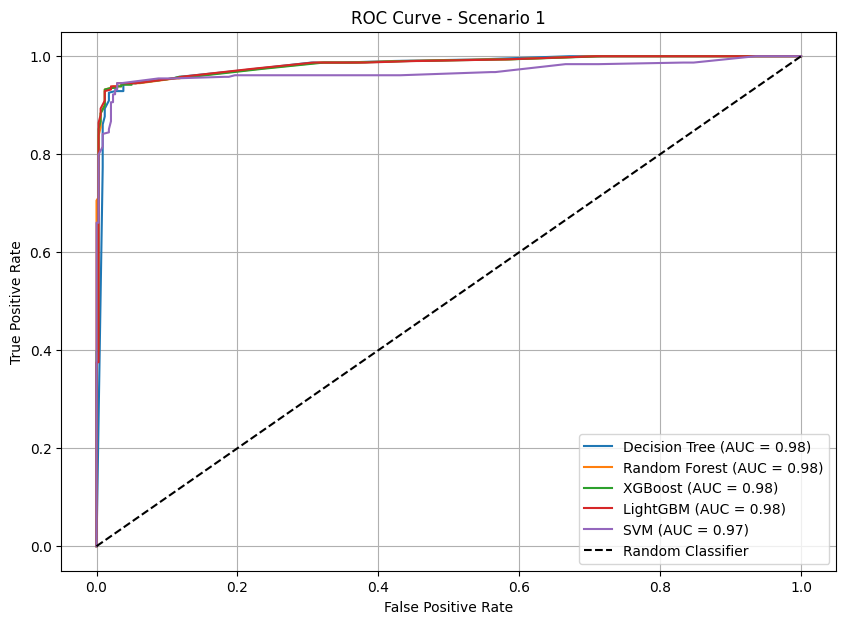

In [ ]:
# ROC Curve Scenario 1
plt.figure(figsize=(10, 7))

# Decision Tree
y_score_dt = model_dt1.predict_proba(X_test1)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test1, y_score_dt)
auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')

# Random Forest
y_score_rf = model_rf1.predict_proba(X_test1)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test1, y_score_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')

# XGBoost
y_score_xgb = model_xgboost1.predict_proba(X_test1)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test1, y_score_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')

# LightGBM
y_score_lgbm = model_lightgbm1.predict_proba(X_test1)[:, 1]
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test1, y_score_lgbm)
auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.2f})')

# SVM (menggunakan decision_function karena tidak ada predict_proba)
y_score_svm = model_svm1.decision_function(X_test1)
fpr_svm, tpr_svm, _ = roc_curve(y_test1, y_score_svm)
auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})')

# Plot garis referensi dan styling
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Scenario 1')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Scenario 2

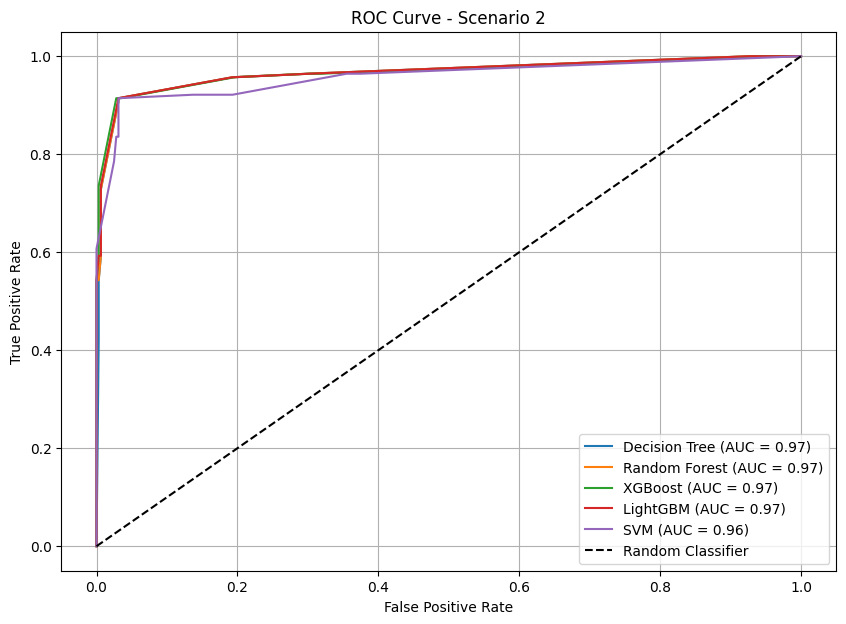

In [ ]:
# ROC Curve Scenario 2
plt.figure(figsize=(10, 7))

# Decision Tree
y_score_dt = model_dt2.predict_proba(X_test2)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test2, y_score_dt)
auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')

# Random Forest
y_score_rf = model_rf2.predict_proba(X_test2)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test2, y_score_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')

# XGBoost
y_score_xgb = model_xgboost2.predict_proba(X_test2)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test2, y_score_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')

# LightGBM
y_score_lgbm = model_lightgbm2.predict_proba(X_test2)[:, 1]
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test2, y_score_lgbm)
auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.2f})')

# SVM (menggunakan decision_function karena tidak ada predict_proba)
y_score_svm = model_svm2.decision_function(X_test2)
fpr_svm, tpr_svm, _ = roc_curve(y_test2, y_score_svm)
auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})')

# Plot garis referensi dan styling
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Scenario 2')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()